<a href="https://colab.research.google.com/github/electricshadok/notebooks/blob/main/gan_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Understanding Generative Adversarial Network (GAN)

A simple Generative Adversarial Network (GAN) that learns a 2D distribution.

## Packages

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

## 1. Generate Synthetic Data

We create a dataset of 2D points sampled from a Gaussian Mixture Model (GMM). This simulates data from a real-world distribution that we want the EBM to learn.

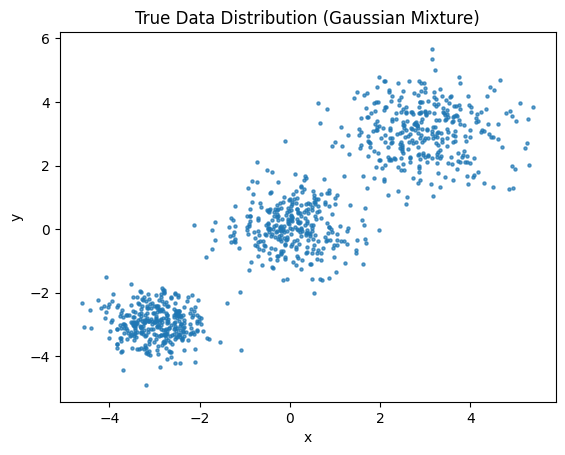

In [2]:
NUM_POINTS = 1000  # Total number of points
SEED = 42  # Seed for reproducibility

# Create synthetic data: Gaussian mixture
def sample_gaussian_mixture(n_samples, means, covs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    n_components = len(means)
    samples = []
    for _ in range(n_samples):
        k = np.random.choice(n_components)  # Randomly select one Gaussian component
        sample = np.random.multivariate_normal(means[k], covs[k])
        samples.append(sample)
    return np.array(samples)

# Parameters of the Gaussian mixture
means = [[0, 0], [3, 3], [-3, -3]]
covs = [np.eye(2) * 0.5, np.eye(2) * 0.8, np.eye(2) * 0.3]

# Generate data
X = sample_gaussian_mixture(NUM_POINTS, means, covs, seed=SEED)

# Visualize the synthetic data
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.7)
plt.title("True Data Distribution (Gaussian Mixture)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 2. Generative Adversarial Network (GAN)

The GAN consists of two models:
- **Generator**: Maps random noise
- **Discriminator**: Distinguishes between real data and generated data.

In [3]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.net(z)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

## 3. Train the Energy Model

**Initialize the Models and Optimizers**

The criterion is a **Binary Cross-Entropy Loss (BCE Loss)** and ranges in $[0, \infty)$.


- $\hat{y_i}$: Predicted probability (output of the model, typically between $0$ and $1$).
- $\hat{y_i}$ Ground truth label  ($0$ or $1$).
- $N$: Number of samples in the batch.

$$\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]$$


In [4]:
# Model dimensions
noise_dim = 2  # Dimension of the noise vector
data_dim = 2   # Dimension of the data (x, y)

# Instantiate models
generator = Generator(noise_dim, data_dim)
discriminator = Discriminator(data_dim)

# Optimizers
lr = 0.001
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
bce_loss = nn.BCELoss()  # Binary cross-entropy loss


**Training the GAN**
$ $

**Stage 1- Discriminator Training**

1. Real Data
    - Randomly sample a batch of real data points from the dataset.
    - Pass them through the discriminator to compute predictions $P(\text{real}|x)$

2. Fake Data
    - Generate a batch of fake data using the generator.
    - Pass it through the discriminator to compute predictions $P(\text{real}|x_{fake})$

3. Use binary cross-entropy loss
    - Real data labeled as $1$
    - Fake data labeled as $0$

4. Update Discriminator
    - Backpropagate and optimize the discriminator’s parameters

Note: Often, the discriminator is trained more frequently than the generator to stabilize learning (e.g., 2-5 updates for each generator update)

**Stage 2- Generator Training**

1. Generate Fake Data
    - Use random noise as input to the generator to produce fake samples.

2. Discriminator Feedback
    - Pass the fake data through the discriminator.
    - The discriminator predicts the probability that the fake data is real.

3. Use binary cross-entropy loss
    - The generator tries to fool the discriminator, so the fake data is labeled as $1$.

4. Update Discriminator
    - Backpropagate and optimize the generator’s parameters


In [5]:
# Training Loop
NUM_EPOCHS = 1000
BATCH_SIZE = 128
NUM_DISC_UPDATES = 2

X_tensor = torch.tensor(X, dtype=torch.float32)

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress"):
    # Stage 1 - Discriminator Training
    for _ in range(NUM_DISC_UPDATES):
        # sample real data
        idx = np.random.randint(0, len(X), size=BATCH_SIZE)
        real_data = X_tensor[idx]

        # generate fake data
        z = torch.randn(BATCH_SIZE, noise_dim)
        fake_data = generator(z)

        # discriminator predictions
        real_pred = discriminator(real_data)
        fake_pred = discriminator(fake_data.detach())

        # discriminator loss
        real_loss = bce_loss(real_pred, torch.ones_like(real_pred))  # Real data labeled as 1
        fake_loss = bce_loss(fake_pred, torch.zeros_like(fake_pred))  # Fake data labeled as 0
        disc_loss = real_loss + fake_loss

        # update discriminator
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

    # Stage 2 - Generator Training
    z = torch.randn(BATCH_SIZE, noise_dim)
    fake_data = generator(z)
    fake_pred = discriminator(fake_data)

    # generator loss
    gen_loss = bce_loss(fake_pred, torch.ones_like(fake_pred))

    # update generator
    gen_optimizer.zero_grad()
    gen_loss.backward()
    gen_optimizer.step()

    # Optional: Print losses every few epochs
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{NUM_EPOCHS}], Discriminator Loss: {disc_loss.item()}, Generator Loss: {gen_loss.item()}")



Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [0/1000], Discriminator Loss: 1.217956304550171, Generator Loss: 0.6355668306350708
Epoch [100/1000], Discriminator Loss: 1.320000410079956, Generator Loss: 0.9524393081665039
Epoch [200/1000], Discriminator Loss: 0.7489227056503296, Generator Loss: 1.315542459487915
Epoch [300/1000], Discriminator Loss: 1.279224157333374, Generator Loss: 0.9481824636459351
Epoch [400/1000], Discriminator Loss: 1.282327651977539, Generator Loss: 1.0461385250091553
Epoch [500/1000], Discriminator Loss: 1.1373622417449951, Generator Loss: 1.029219388961792
Epoch [600/1000], Discriminator Loss: 1.2016154527664185, Generator Loss: 0.9304591417312622
Epoch [700/1000], Discriminator Loss: 1.3586088418960571, Generator Loss: 0.9231169819831848
Epoch [800/1000], Discriminator Loss: 1.1380025148391724, Generator Loss: 0.9480172991752625
Epoch [900/1000], Discriminator Loss: 1.1801352500915527, Generator Loss: 0.8780630826950073


## 4. Visualization

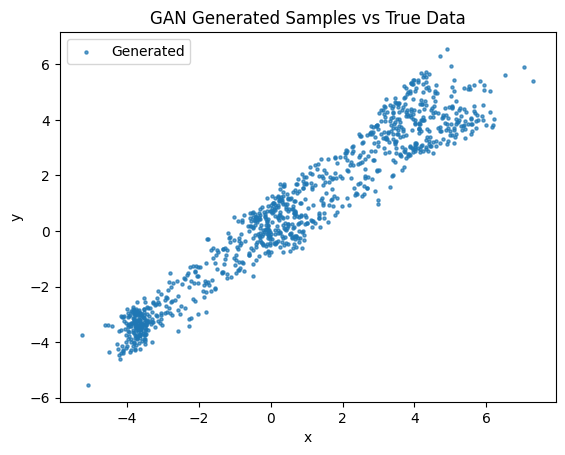

In [6]:
n_samples = 1000
noise = torch.randn(n_samples, noise_dim)
gen_X = generator(noise).detach().numpy()

plt.scatter(gen_X[:, 0], gen_X[:, 1], s=5, alpha=0.7, label="Generated")
#plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.7, label="True Data")
plt.title("GAN Generated Samples vs True Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()